In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

#### Load Anomalies Datasets

In [2]:
df = pd.read_csv('mid_cap_all_sectors_ret.csv', parse_dates=['date'])
df.set_index('date', inplace=True)

train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]
test_data.to_csv('test_set.csv', index=True)

FileNotFoundError: [Errno 2] No such file or directory: 'mid_cap_all_sectors_ret.csv'

In [5]:
anomalies_lstm = pd.read_csv('Anomalies Dataset/lstm.csv', index_col='date', parse_dates=True)
anomalies_cnn = pd.read_csv('Anomalies Dataset/cnn.csv', index_col='date', parse_dates=True)
anomalies_isoforest = pd.read_csv('Anomalies Dataset/isolation_with_financialcrisis.csv', index_col='date', parse_dates=True)
anomalies_knn = pd.read_csv('Anomalies Dataset/knn.csv', index_col='date', parse_dates=True)
anomalies_statistical = pd.read_csv('Anomalies Dataset/statistics.csv', index_col='date', parse_dates=True)
anomalies_mahalanobis = pd.read_csv('Anomalies Dataset/mahalanobis_distance.csv', index_col='date', parse_dates=True)

#### EDA

In [6]:
dates_match = (
    anomalies_lstm.index.equals(anomalies_cnn.index) and
    anomalies_lstm.index.equals(anomalies_knn.index) and
    anomalies_lstm.index.equals(anomalies_isoforest.index) and
    anomalies_lstm.index.equals(anomalies_statistical.index) and
    anomalies_lstm.index.equals(anomalies_mahalanobis.index)
)
print(f"Do all datasets have matching dates? {dates_match}")

columns_match = (
    anomalies_lstm.columns.equals(anomalies_cnn.columns) and
    anomalies_lstm.columns.equals(anomalies_knn.columns) and
    anomalies_lstm.columns.equals(anomalies_isoforest.columns) and
    anomalies_lstm.columns.equals(anomalies_statistical.columns) and
    anomalies_lstm.columns.equals(anomalies_mahalanobis.columns)
)
print(f"Do all datasets have matching sectors? {columns_match}")

Do all datasets have matching dates? True
Do all datasets have matching sectors? True


In [7]:
# combining dataset
anomalies_dict = {
    'LSTM': anomalies_lstm,
    'CNN': anomalies_cnn,
    'KNN': anomalies_knn,
    'IsolationForest': anomalies_isoforest,
    'Statistical': anomalies_statistical,
    'Mahalanobis': anomalies_mahalanobis
}

anomalies_combined = pd.concat(anomalies_dict, axis=1)

In [8]:
sectors = anomalies_lstm.columns
models = list(anomalies_dict.keys())

anomaly_counts = pd.DataFrame(index=sectors, columns=models)

for model in models:
    anomalies = anomalies_dict[model]
    anomaly_counts[model] = anomalies.sum()

print("Anomaly Counts per Sector and Model:")
print(anomaly_counts)

Anomaly Counts per Sector and Model:
                         LSTM  CNN  KNN  IsolationForest  Statistical  \
Materials               121.0  147    9              100           17   
Industrials             128.0  209   12              108           22   
Health Care              55.0   11    6               57           13   
Real Estate              82.0  397   13               92            9   
Consumer Discretionary  144.0  380    9              130            6   
Financials              128.0  180   19              141           24   
Utilities               144.0  189   15              126           28   
Information Technology   39.0   52    8               50            8   
Energy                  208.0   42    5              155           23   
Consumer Staples         52.0  399    1               58           11   
Communication Services   39.0   31    5               47           16   

                        Mahalanobis  
Materials                        14  
Industrial

In [9]:
# Percentage of anomalies over total number of observations
num_observations = anomalies_lstm.shape[0]
anomaly_percentages = (anomaly_counts / num_observations) * 100

print("Percentage of Anomalies per Sector and Model:")
anomaly_percentages

Percentage of Anomalies per Sector and Model:


,LSTM,CNN,KNN,IsolationForest,Statistical,Mahalanobis
Materials,9.750201,11.845286,0.725222,8.058018,1.369863,1.128122
Industrials,10.314263,16.841257,0.966962,8.702659,1.772764,0.966962
Health Care,4.431910,0.886382,0.483481,4.593070,1.047542,0.241741
Real Estate,6.607575,31.990330,1.047542,7.413376,0.725222,0.886382
Consumer Discretionary,11.603546,30.620467,0.725222,10.475423,0.483481,2.739726
Financials,10.314263,14.504432,1.531023,11.361805,1.933924,1.531023
Utilities,11.603546,15.229654,1.208703,10.153102,2.256245,1.208703
Information Technology,3.142627,4.190169,0.644641,4.029009,0.644641,0.644641
Energy,16.760677,3.384367,0.402901,12.489927,1.853344,1.611604
Consumer Staples,4.190169,32.151491,0.080580,4.673650,0.886382,0.564061


In [10]:
anomaly_percentages.corr()

,LSTM,CNN,KNN,IsolationForest,Statistical,Mahalanobis
LSTM,1.000000,0.052875,0.334443,0.957586,0.561401,0.660315
CNN,0.052875,1.000000,0.132982,0.166420,-0.346501,0.300511
KNN,0.334443,0.132982,1.000000,0.534099,0.449937,0.264005
IsolationForest,0.957586,0.166420,0.534099,1.000000,0.547728,0.712829
Statistical,0.561401,-0.346501,0.449937,0.547728,1.000000,0.030991
Mahalanobis,0.660315,0.300511,0.264005,0.712829,0.030991,1.000000


In [10]:
# percentage of anomalies across sectors
num_anomaly_by_model = anomaly_counts.sum()
anomaly_percent_sector = anomaly_counts / num_anomaly_by_model

anomaly_percent_sector

,LSTM,CNN,KNN,IsolationForest,Statistical,Mahalanobis
Materials,0.106140,0.072165,0.088235,0.093985,0.096045,0.089744
Industrials,0.112281,0.102602,0.117647,0.101504,0.124294,0.076923
Health Care,0.048246,0.005400,0.058824,0.053571,0.073446,0.019231
Real Estate,0.071930,0.194894,0.127451,0.086466,0.050847,0.070513
Consumer Discretionary,0.126316,0.186549,0.088235,0.122180,0.033898,0.217949
Financials,0.112281,0.088365,0.186275,0.132519,0.135593,0.121795
Utilities,0.126316,0.092784,0.147059,0.118421,0.158192,0.096154
Information Technology,0.034211,0.025528,0.078431,0.046992,0.045198,0.051282
Energy,0.182456,0.020619,0.049020,0.145677,0.129944,0.128205
Consumer Staples,0.045614,0.195876,0.009804,0.054511,0.062147,0.044872


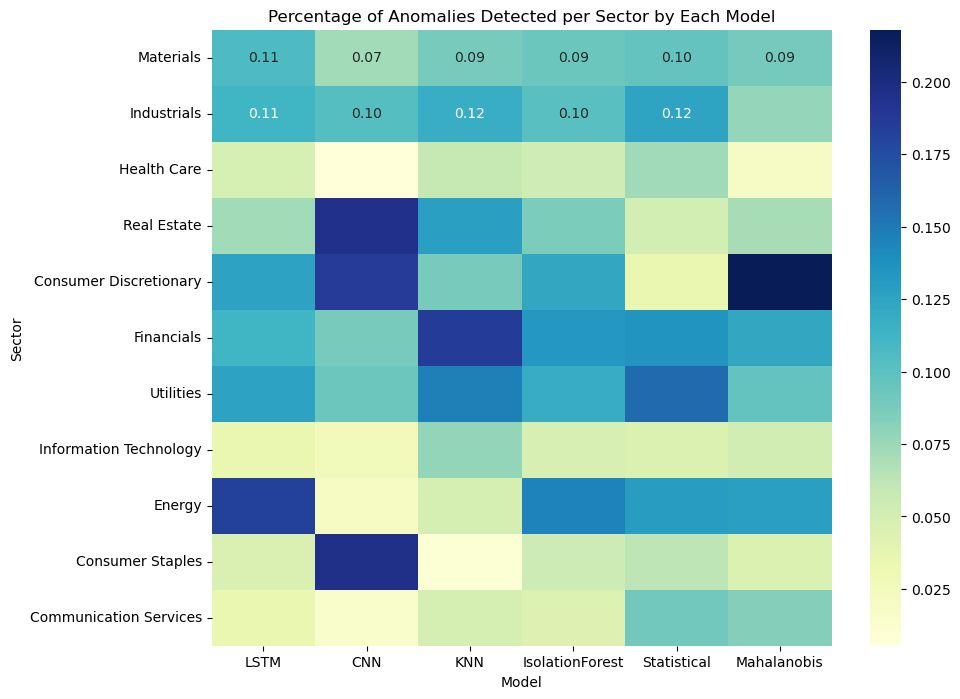

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(anomaly_percent_sector.astype(float), annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Percentage of Anomalies Detected per Sector by Each Model')
plt.xlabel('Model')
plt.ylabel('Sector')
plt.show()

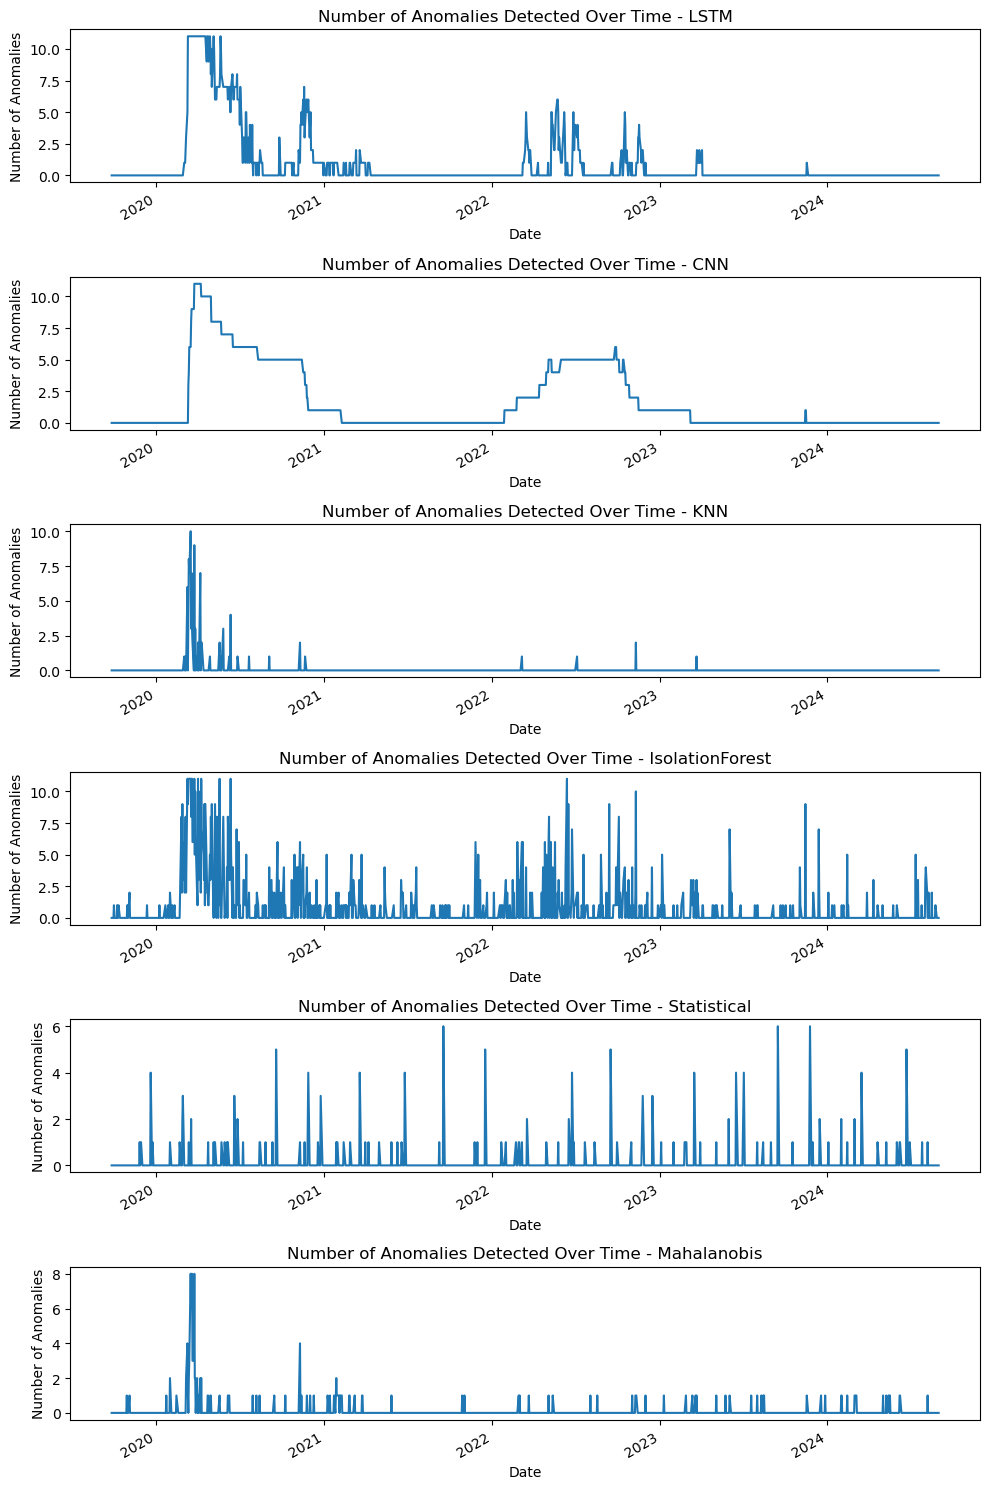

In [12]:
# Distribution of Anomalies
fig, axes = plt.subplots(len(models), 1, figsize=(10, 2.5 * len(models)))

for i, model in enumerate(models):
    anomalies = anomalies_dict[model]
    anomalies_per_date = anomalies.sum(axis=1)
    
    ax = axes[i]
    anomalies_per_date.plot(ax=ax)
    ax.set_title(f'Number of Anomalies Detected Over Time - {model}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Anomalies')

plt.tight_layout()
plt.show()

Jaccard Similarity Index Between Models:


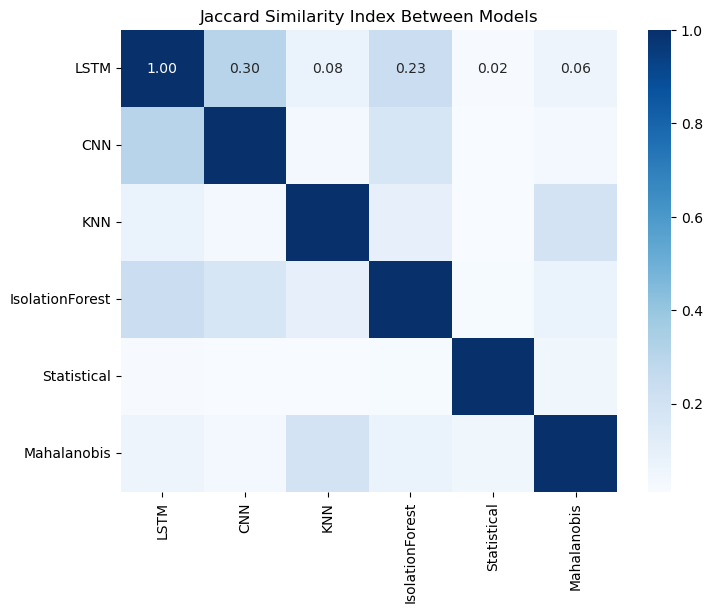

In [13]:
def jaccard_similarity(anomalies1, anomalies2):
    anomalies1_flat = anomalies1.values.flatten()
    anomalies2_flat = anomalies2.values.flatten()
    intersection = np.logical_and(anomalies1_flat == 1, anomalies2_flat == 1).sum()
    union = np.logical_or(anomalies1_flat == 1, anomalies2_flat == 1).sum()
    if union == 0:
        return np.nan
    return intersection / union

jaccard_df = pd.DataFrame(index=models, columns=models)

for model1, model2 in combinations(models, 2):
    sim = jaccard_similarity(anomalies_dict[model1], anomalies_dict[model2])
    jaccard_df.loc[model1, model2] = sim
    jaccard_df.loc[model2, model1] = sim

np.fill_diagonal(jaccard_df.values, 1.0)

print("Jaccard Similarity Index Between Models:")
jaccard_df

plt.figure(figsize=(8, 6))
sns.heatmap(jaccard_df.astype(float), annot=True, cmap='Blues', fmt=".2f")
plt.title('Jaccard Similarity Index Between Models')
plt.show()

Number of consensus anomalies (detected by at least 4 models): 50


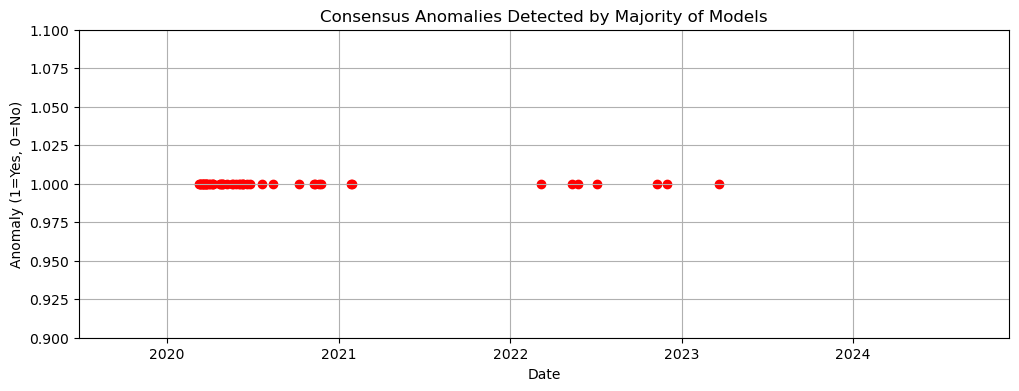

In [14]:
anomalies_flat = pd.DataFrame(index=anomalies_lstm.index)

for model in models:
    # An anomaly is detected if any sector has an anomaly on that date
    anomalies_flat[model] = anomalies_dict[model].any(axis=1).astype(int)

anomalies_sum = anomalies_flat.sum(axis=1)

# Anomalies detected by at least 3 models (majority)
consensus_threshold = len(models) // 2 + 1
consensus_anomalies = anomalies_sum >= consensus_threshold

print(f"Number of consensus anomalies (detected by at least {consensus_threshold} models): {consensus_anomalies.sum()}")

plt.figure(figsize=(12, 4))
plt.scatter(consensus_anomalies.index, consensus_anomalies.astype(int), marker='o', color='red')
plt.title('Consensus Anomalies Detected by Majority of Models')
plt.xlabel('Date')
plt.ylabel('Anomaly (1=Yes, 0=No)')
plt.ylim(0.9, 1.1)
plt.grid(True)
plt.show()

#### Majority Models Consensus Anomaly

In [49]:
sector_anomaly_consensus = {}
consensus_threshold = 3

for sector in anomalies_lstm.columns: 
    anomaly_flat_sector = pd.DataFrame(index = anomalies_lstm.index)

    for model in models:
        anomaly_flat_sector[model] = anomalies_dict[model][sector]

    anomaly_sum_sector = anomaly_flat_sector.sum(axis=1)
    sector_anomaly_consensus[sector] = (anomaly_sum_sector >= consensus_threshold).astype(int)

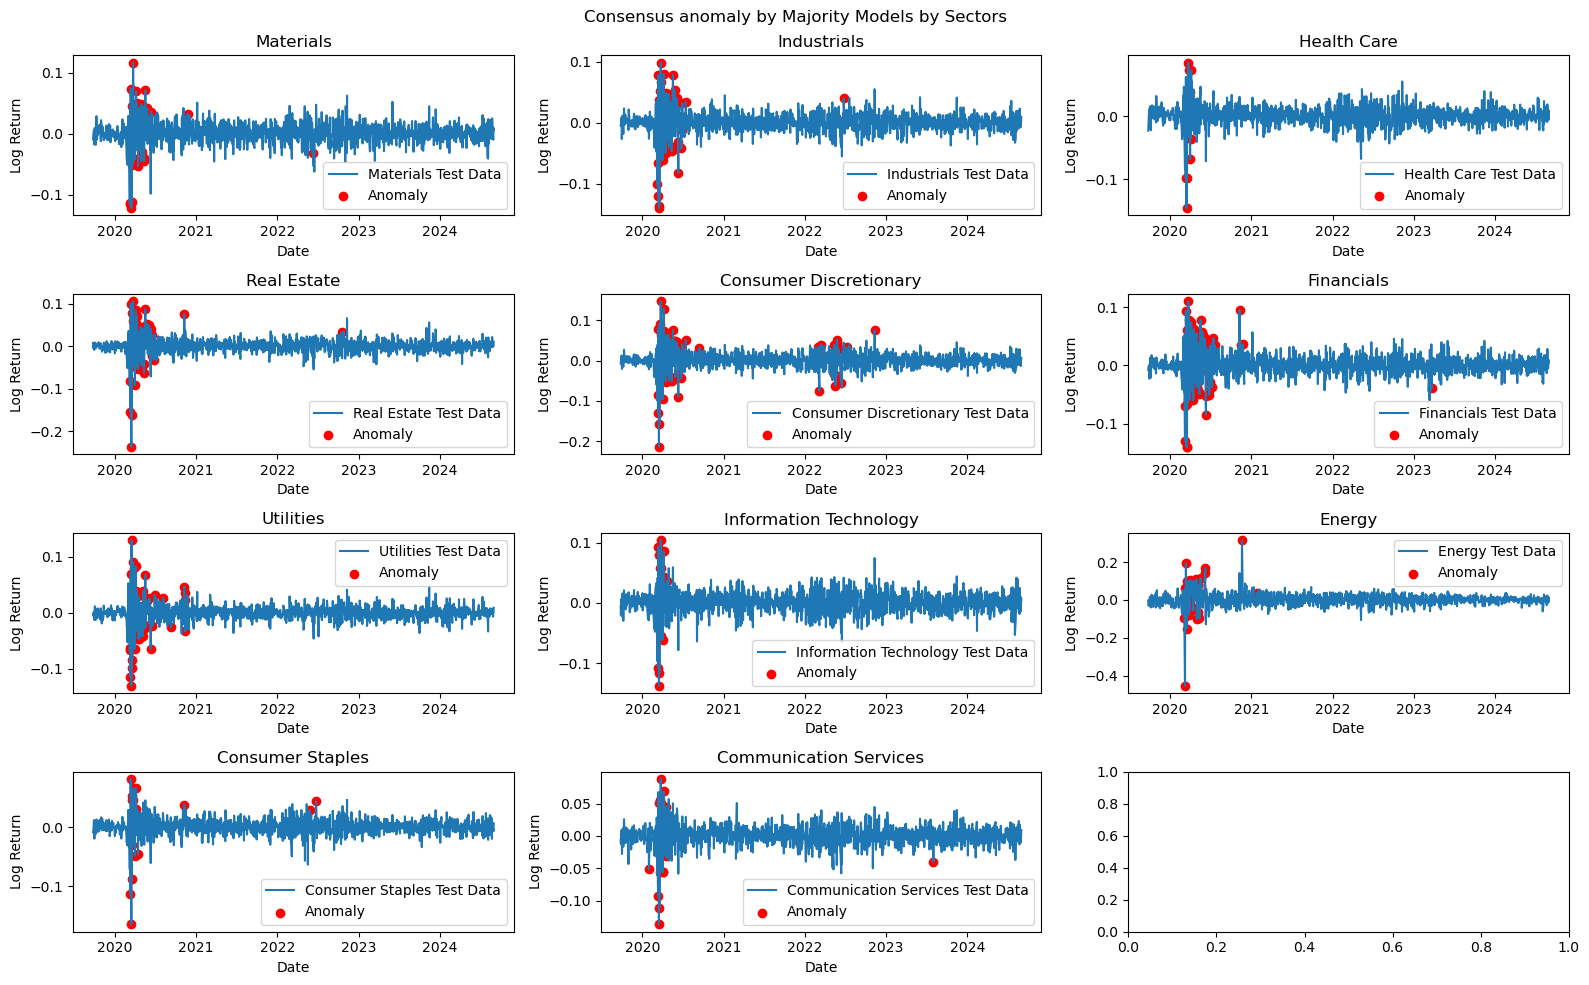

In [50]:
fig, axes = plt.subplots(4, 3, figsize=(16, 10))
fig.suptitle('Consensus anomaly by Majority Models by Sectors')
fig.tight_layout(pad=3.0)

for i, sector in enumerate(anomalies_lstm.columns):
    ax = axes.flatten()[i]

    sector_test = test_data[sector]

    ax.plot(sector_test.index, sector_test.values, label=f'{sector} Test Data')

    consensus_anomaly = sector_anomaly_consensus[sector]
    anomaly_dates = consensus_anomaly[consensus_anomaly == 1].index

    anomaly_values = test_data.loc[anomaly_dates, sector]

    ax.scatter(anomaly_dates, anomaly_values, color='r', marker='o', label='Anomaly')

    ax.set_title(f'{sector}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.legend()

plt.tight_layout()
plt.show()